Device available: cuda
Dự đoán mục tiêu: daily_return_log (Log-Return) -> Ép dự đoán độ dốc!

--- 1. Long-Term NLinear (Global Trend) ---

--- 2. Short-Term NLinear (Local Trend/Return) ---

Meta-Ensemble: 0.01 * Long(L=240) + 0.99 * Short(L=15)
Post-processing: Đã áp dụng EMA 0.5 & Stochastic Noise 0.01

✅ Đã lưu submission_final.csv


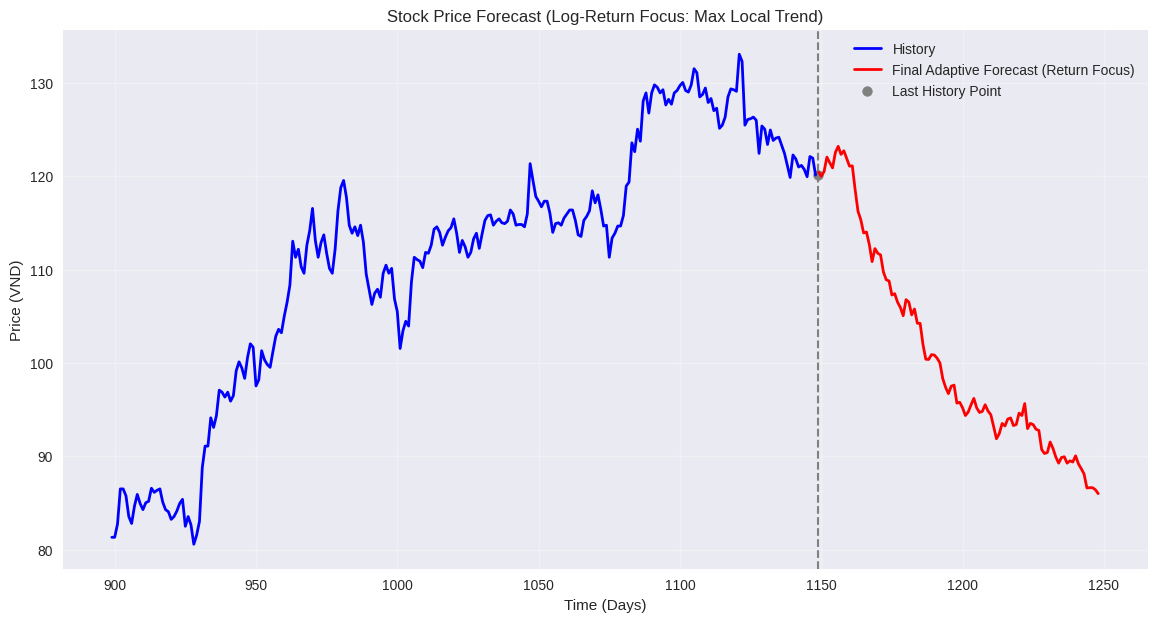

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math
import random
import os

# --- Cấu hình Môi trường ---
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device available: {device}")

# =========================================================================
# ===== THAM SỐ CẤU HÌNH LOG-RETURN (MAX LOCAL FOCUS) =====
# --- Mục tiêu: Dự đoán Log-Return thay vì Log-Price ---
TARGET_COL = 'daily_return_log' # Cột mới: Log-Return
PREDICT_RETURN = True

# --- MÔ HÌNH 1: NLinear Long-Term (Global Context) ---
L1 = 240            
K1 = 10             
S1 = 10             
WEIGHT_LONG = 0.01  

# --- MÔ HÌNH 2: NLinear Short-Term (Local Trend/Return Dominance) ---
L2 = 15             # L2: Cực đại hóa sự tập trung ngắn hạn (3 tuần)
K2 = 10             
S2 = 1              # S2: Trượt từng ngày một cho ensemble (Độ chính xác cao)
WEIGHT_SHORT = 0.99

# --- Cấu hình Chung ---
TOTAL_PREDICT_DAYS = 100
T = 100             
NUM_EPOCHS = 150    # Tăng Epoch vì Log-Return khó học hơn
BATCH_SIZE = 32
# --- Cấu hình Hậu Xử Lý ---
ALPHA_EMA = 0.5     # Tăng Alpha (0.5) để GIẢM LÀM TRƠN
STOCHASTIC_FACTOR = 0.01 # Biên độ nhiễu ngẫu nhiên (Log Space)
# =========================================================================

# Chuẩn hóa trọng số
total_weight = WEIGHT_LONG + WEIGHT_SHORT
WEIGHT_LONG /= total_weight
WEIGHT_SHORT /= total_weight

# Tính toán lịch sử cần thiết
L_NEEDED_1 = L1 + (K1 - 1) * S1
L_NEEDED_2 = L2 + (K2 - 1) * S2
L_NEEDED_HISTORY = max(L_NEEDED_1, L_NEEDED_2)


# --- 1. Load và Tiền xử lý Dữ liệu (Dùng Log-Return) ---
df = pd.read_csv('/kaggle/input/aio-2025-linear-forecasting-challenge/FPT_train.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)
df['close_log'] = np.log(df['close'] + 1e-8)
df[TARGET_COL] = df['close_log'].diff().fillna(0) # TARGET LÀ LOG-RETURN

df_processed = df[[TARGET_COL]].copy()
print(f"Dự đoán mục tiêu: {TARGET_COL} (Log-Return) -> Ép dự đoán độ dốc!")


# ===== 2. MÔ HÌNH NLinear (NLinear trên Log-Return) =====
class NLinear(nn.Module):
    # NLinear vẫn hoạt động tốt trên Log-Return
    def __init__(self, input_len, output_len):
        super(NLinear, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.linear = nn.Linear(input_len, output_len)

    def forward(self, x):
        # x: [B, L]
        last_value = x[:, -1].clone().detach().unsqueeze(1) # [B, 1] - Giá trị return cuối
        x_norm = x - last_value
        pred_norm = self.linear(x_norm) # [B, T]
        pred = pred_norm + last_value
        return pred

# ===== 3. HÀM TRAIN & DỰ ĐOÁN (ĐÃ CHỈNH SỬA) =====
class TimeSeriesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len: int, pred_len: int):
        self.data = df[TARGET_COL].values.astype(np.float32) # Input/Target là Log-Return
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx: int):
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

def train_model(model, input_len, output_len, epochs, batch_size):
    dataset = TimeSeriesDataset(df_processed, input_len, output_len)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
    return model

def predict(model, input_len, output_len, num_ensemble, slide_step):
    model.eval()
    
    weights_raw = np.linspace(1, num_ensemble, num_ensemble)
    weights = weights_raw / weights_raw.sum() 
    weights = weights[::-1] 
    
    L_needed = input_len + (num_ensemble - 1) * slide_step
    # Lấy Log-Return lịch sử làm input
    history_data = df_processed[TARGET_COL].values[-L_needed:].copy()

    with torch.no_grad():
        predictions_matrix = []
        for i in range(num_ensemble):
            start_idx = i * slide_step
            end_idx = start_idx + input_len
            current_input = history_data[start_idx:end_idx]
            
            input_tensor = torch.FloatTensor(current_input).unsqueeze(0).to(device) 
            output = model(input_tensor)
            predictions_matrix.append(output.cpu().numpy().flatten())

        predictions_matrix = np.array(predictions_matrix) 
        weighted_predictions = predictions_matrix * weights[:, np.newaxis] 
        final_predictions_return = np.sum(weighted_predictions, axis=0)
    
    return final_predictions_return

# Hàm làm trơn EMA
def apply_ema(series, alpha):
    ema_series = np.zeros_like(series)
    if len(series) == 0: return ema_series
    ema_series[0] = series[0]
    for i in range(1, len(series)):
        ema_series[i] = alpha * series[i] + (1 - alpha) * ema_series[i-1]
    return ema_series


# ===== 4. HUẤN LUYỆN & DỰ ĐOÁN CUỐI CÙNG (MAX LOCAL FOCUS) =====
# 1. MÔ HÌNH LONG-TERM (NLinear)
print("\n--- 1. Long-Term NLinear (Global Trend) ---")
model_long = NLinear(L1, T)
model_long = train_model(model_long, L1, T, NUM_EPOCHS, BATCH_SIZE)

# 2. MÔ HÌNH SHORT-TERM (NLinear)
print("\n--- 2. Short-Term NLinear (Local Trend/Return) ---")
model_short = NLinear(L2, T)
model_short = train_model(model_short, L2, T, NUM_EPOCHS, BATCH_SIZE)

# 3. INFERENCE VÀ META-ENSEMBLE (Dự đoán Log-Return)
pred_return_long = predict(model_long, L1, T, K1, S1)
pred_return_short = predict(model_short, L2, T, K2, S2)

final_predictions_return_raw = (WEIGHT_LONG * pred_return_long) + (WEIGHT_SHORT * pred_return_short)
print(f"\nMeta-Ensemble: {WEIGHT_LONG:.2f} * Long(L={L1}) + {WEIGHT_SHORT:.2f} * Short(L={L2})")

# 4. POST-PROCESSING: EMA và THÊM NHIỄU
forecast_return_smooth = apply_ema(final_predictions_return_raw, ALPHA_EMA)

# Thêm nhiễu ngẫu nhiên (chỉ thêm nhiễu vào độ dốc)
noise_base = np.random.normal(0, STOCHASTIC_FACTOR, size=T)
forecast_return_final = forecast_return_smooth + noise_base
print(f"Post-processing: Đã áp dụng EMA {ALPHA_EMA} & Stochastic Noise {STOCHASTIC_FACTOR}")

# 5. HOÀN NGUYÊN TỪ RETURN VỀ GIÁ (Từ Log-Return về Log-Price)
last_close_log = df['close_log'].values[-1]

# Log-Price = last_Log_Price + Cumulative Sum of Returns
# np.cumsum(forecast_return_final): dự đoán thay đổi giá tích lũy
forecast_log_price = last_close_log + np.cumsum(forecast_return_final)

# Chuyển đổi từ log về giá close
forecast_price_final = np.exp(forecast_log_price)
# NLinear trên Log-Return đảm bảo điểm đầu tiên của dự đoán gần bằng giá trị cuối cùng của lịch sử (do Log-Return của ngày đầu tiên được dự đoán sẽ cộng vào Log-Price cuối cùng)

# ===== 6. LƯU VÀ VISUALIZATION =====
submission = pd.DataFrame({'id': range(1, TOTAL_PREDICT_DAYS + 1), 'close': forecast_price_final})
output_filename = 'submission_final.csv'
submission.to_csv(output_filename, index=False)
print(f"\n✅ Đã lưu {output_filename}")

# Visualization
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(14, 7))

history_len = 250
full_history_price = np.exp(df['close_log'].values)
last_hist_log = full_history_price[-1]
last_hist_idx = len(full_history_price)
history_index = range(last_hist_idx - history_len, last_hist_idx)
future_index = range(last_hist_idx, last_hist_idx + TOTAL_PREDICT_DAYS)

plt.plot(history_index, full_history_price[-history_len:], 
         label='History', color='blue', linewidth=2)
plt.plot(future_index, forecast_price_final, 
         label=f'Final Adaptive Forecast (Return Focus)', 
         color='red', linewidth=2)
plt.axvline(last_hist_idx, color='gray', linestyle='--', linewidth=1.5)
plt.scatter(last_hist_idx, last_hist_log, color='gray', s=50, marker='o', label='Last History Point')

plt.title(f'Stock Price Forecast (Log-Return Focus: Max Local Trend)')
plt.xlabel('Time (Days)')
plt.ylabel('Price (VND)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()